In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from IPython.display import display

Objectif d'étudier les impôts en France en 2024

<ipython-input-2-9e0d123d1a39>:23: RuntimeWarning: invalid value encountered in divide
  taux_moyens = (impots / revenus) * 100


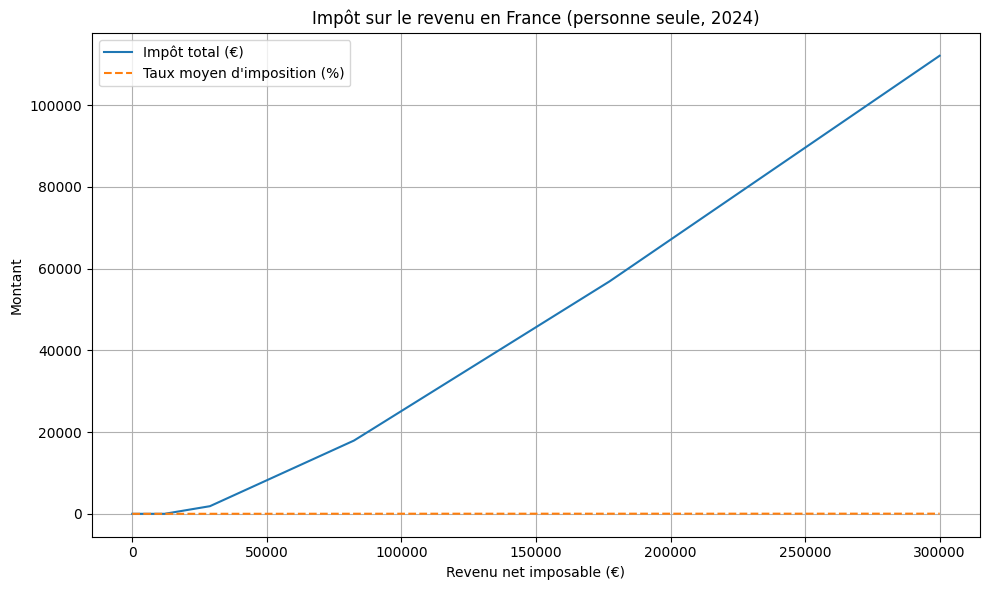

In [2]:
# Création d’un vecteur de revenus imposables de 0 à 300 000 €
revenus = np.linspace(0, 300000, 500)

# Barème de l'impôt sur le revenu 2024 pour une personne seule
tranches = [0, 11994, 28797, 82441, 177106]
tauxs = [0, 0.11, 0.30, 0.41, 0.45]

def impot_revenu_france(revenu):
    impot = 0
    for i in range(1, len(tranches)):
        bas = tranches[i - 1]
        haut = tranches[i]
        if revenu > bas:
            impot += (min(revenu, haut) - bas) * tauxs[i - 1]
    if revenu > tranches[-1]:
        impot += (revenu - tranches[-1]) * tauxs[-1]
    return impot

# Calcul de l'impôt pour chaque revenu
impots = np.array([impot_revenu_france(r) for r in revenus])

# Taux moyen d’imposition en %
taux_moyens = (impots / revenus) * 100
taux_moyens[revenus == 0] = 0  # éviter division par 0

# Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(revenus, impots, label="Impôt total (€)")
plt.plot(revenus, taux_moyens, label="Taux moyen d'imposition (%)", linestyle="--")
plt.xlabel("Revenu net imposable (€)")
plt.ylabel("Montant")
plt.title("Impôt sur le revenu en France (personne seule, 2024)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


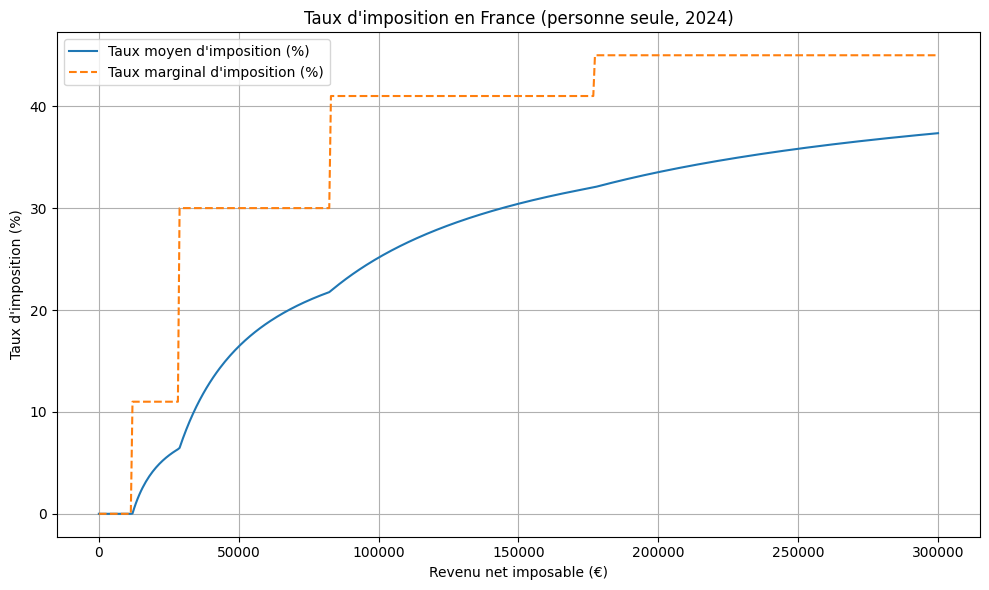

In [3]:
# Représenter uniquement les taux marginaux et moyens en pourcentage

# Calcul du taux marginal à chaque tranche
taux_marginaux = np.zeros_like(revenus)

for i in range(1, len(tranches)):
    taux_marginaux[(revenus > tranches[i - 1]) & (revenus <= tranches[i])] = tauxs[i - 1]
taux_marginaux[revenus > tranches[-1]] = tauxs[-1]
taux_marginaux *= 100  # pourcentage

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(revenus, taux_moyens, label="Taux moyen d'imposition (%)", linestyle="-")
plt.plot(revenus, taux_marginaux, label="Taux marginal d'imposition (%)", linestyle="--")
plt.xlabel("Revenu net imposable (€)")
plt.ylabel("Taux d'imposition (%)")
plt.title("Taux d'imposition en France (personne seule, 2024)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Nous observons que le taux d’imposition est une fonction concave. La fonction du taux moyen d’imposition est croissante et convergente. Nous allons donc l’approximer par une fonction de la forme :

$$
f(x) = a_0 + a_1 e^{a_2 x}
$$

avec $a_1 < 0$ et $a_2 < 0$.

Le choix de la fonction exponentielle s’explique par ses propriétés analytiques intéressantes. En outre, opter pour une autre forme fonctionnelle n’aurait pas d’impact significatif sur les erreurs à minimiser, du fait de la concavité de la fonction : les erreurs tendent naturellement à diminuer.


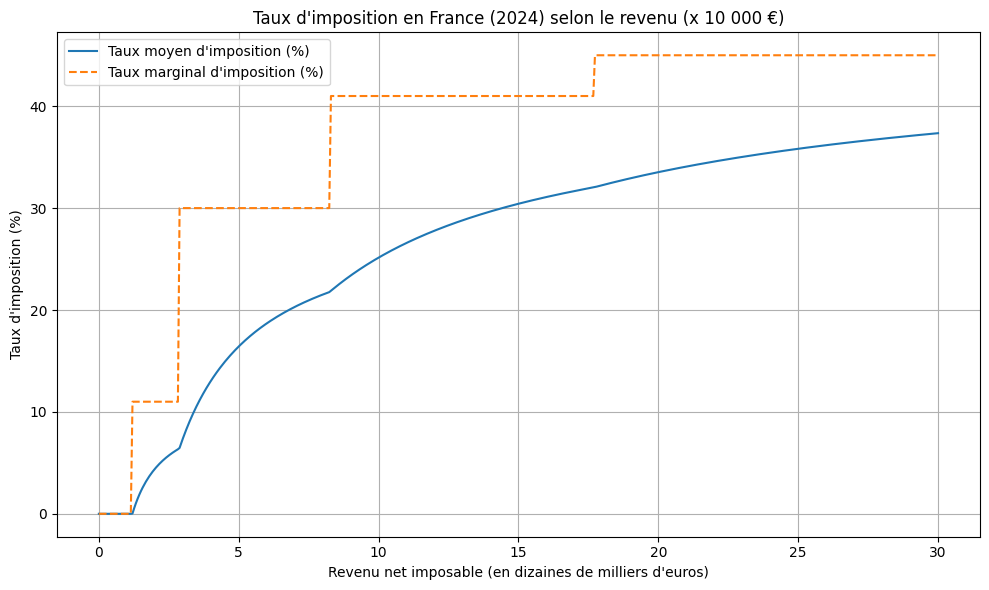

In [4]:
# Revenus bruts divisés par 10 000 pour l'affichage (approche plus intuitive)
revenus_div10k = revenus / 10000

# Tracé en fonction du revenu brut en unités de 10 000 €
plt.figure(figsize=(10, 6))
plt.plot(revenus_div10k, taux_moyens, label="Taux moyen d'imposition (%)", linestyle='-')
plt.plot(revenus_div10k, taux_marginaux, label="Taux marginal d'imposition (%)", linestyle='--')
plt.xlabel("Revenu net imposable (en dizaines de milliers d'euros)")
plt.ylabel("Taux d'imposition (%)")
plt.title("Taux d'imposition en France (2024) selon le revenu (x 10 000 €)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-5-5ebd0e55c3fb>:16: RuntimeWarning: invalid value encountered in divide
  taux_effectifs = (impots_recalculés / revenus_bruts) * 100


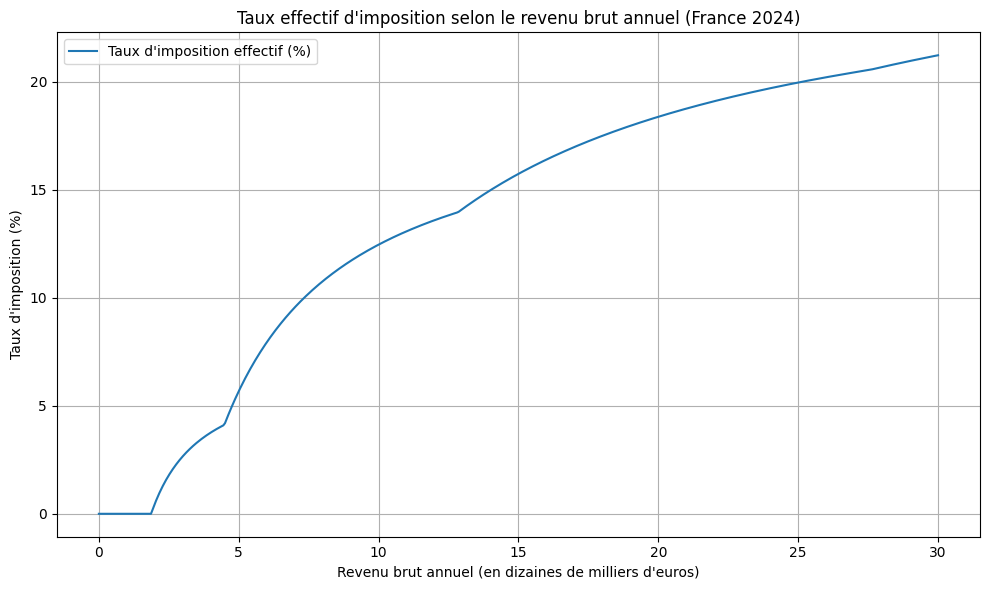

In [5]:
# Formule simplifiée pour passer du brut annuel au revenu net imposable :
# - cotisations salariales estimées : 22 % du brut
# - CSG déductible : ~6.8 % du brut (sur 98.25 % du brut)
# - déduction forfaitaire de 10 % pour frais pro

def brut_to_imposable(brut):
    net_avant_impot = brut * (1 - 0.22)
    csg_deductible = brut * 0.9825 * 0.068
    net_imposable = net_avant_impot - csg_deductible
    return net_imposable * 0.9  # déduction forfaitaire de 10 %

# Recalcul des revenus imposables à partir des bruts
revenus_bruts = np.linspace(0, 300000, 500)
revenus_imposables = np.array([brut_to_imposable(b) for b in revenus_bruts])
impots_recalculés = np.array([impot_revenu_france(r) for r in revenus_imposables])
taux_effectifs = (impots_recalculés / revenus_bruts) * 100
taux_effectifs[revenus_bruts == 0] = 0  # éviter division par 0

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(revenus_bruts / 10000, taux_effectifs, label="Taux d'imposition effectif (%)")
plt.xlabel("Revenu brut annuel (en dizaines de milliers d'euros)")
plt.ylabel("Taux d'imposition (%)")
plt.title("Taux effectif d'imposition selon le revenu brut annuel (France 2024)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
def modele_exp(x, a0, a1, a2):
    return a0 + a1 * np.exp(a2 * x)

In [7]:
bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, 0, 0])
p0 = [1, -10, -1]

# Fonction de fitting sécurisée
def fit_tranche(xdata, ydata):
    try:
        coeffs, _ = curve_fit(modele_exp, xdata, ydata, p0=p0, bounds=bounds, maxfev=5000)
        return coeffs
    except RuntimeError:
        return [np.nan, np.nan, np.nan]

In [8]:
from scipy.special import lambertw

def economie_dechelle(a0,a1,a2):
  quotient=a0/(a1*(np.e))
  issue1,issue2=lambertw(quotient,k=0),lambertw(quotient,k=-1)
  return (issue1+1)/a2,(issue2+1)/a2

### Recherche d’un point d’économie d’échelle fiscale

Nous souhaitons déterminer à partir de quel niveau de revenu $x$ celui-ci augmente plus rapidement que le **taux moyen d’imposition**. Autrement dit, nous cherchons le point où le **revenu marginal net** devient plus favorable, ce qui revient à résoudre l’équation suivante :

$$
\left( \frac{f(x)}{x} \right)' = 0
$$

où $f(x) = a_0 + a_1 e^{a_2 x}$ est la fonction modélisant le taux moyen d’imposition.

Nous cherchons donc la valeur de $x$ telle que :

$$
\left( \frac{a_0 + a_1 e^{a_2 x}}{x} \right)' = 0
$$

### Résolution analytique

Cette équation admet une solution fermée en utilisant la **fonction de Lambert W**. La solution s’écrit :

$$
x = \frac{1 + W\left( \frac{a_0}{a_1 e} \right)}{a_2}
$$

où $W$ est la **fonction de Lambert W**, définie comme l’inverse de $w \mapsto w e^w$.



In [9]:
x = revenus_bruts[revenus_bruts > 0] / 10000  # éviter le 0 pour l'exponentielle, en unités de 10k€
y = taux_effectifs[revenus_bruts > 0]

In [10]:
# Recalcul des tranches à partir du revenu BRUT divisé par 10 000
# Barème en tranches de revenu imposable : 11 994, 28 797, 82 441, 177 106 €
# On inverse le calcul de brut pour approximer ces seuils en brut :
# On estime brut ≈ imposable / 0.715 pour moyenne (à cause des cotisations et abattement forfaitaire)
seuils_imposables = np.array([11994, 28797, 82441, 177106])
seuils_bruts_approx = seuils_imposables / 0.715  # inverse approx du brut → imposable
seuils_bruts_approx_10k = seuils_bruts_approx / 10000  # pour les x en base 10k

# Nouvelle découpe des tranches selon le brut
tranche_1_idx = x <= seuils_bruts_approx_10k[0]
tranche_2_idx = (x > seuils_bruts_approx_10k[0]) & (x <= seuils_bruts_approx_10k[1])
tranche_3_idx = (x > seuils_bruts_approx_10k[1]) & (x <= seuils_bruts_approx_10k[2])
tranche_4_idx = (x > seuils_bruts_approx_10k[2]) & (x <= seuils_bruts_approx_10k[3])
tranche_5_idx = x > seuils_bruts_approx_10k[3]
tranche_ajusté_idx = x > seuils_bruts_approx_10k[0]
# Extraire les tranches corrigées
x1, y1 = x[tranche_1_idx], y[tranche_1_idx]
x2, y2 = x[tranche_2_idx], y[tranche_2_idx]
x3, y3 = x[tranche_3_idx], y[tranche_3_idx]
x4, y4 = x[tranche_4_idx], y[tranche_4_idx]
x5, y5 = x[tranche_5_idx], y[tranche_5_idx]
x_tranche_ajusté, y_tranche_ajusté = x[tranche_ajusté_idx], y[tranche_ajusté_idx]
# Nouveaux ajustements
coeffs_total = fit_tranche(x, y)
coeffs_total_ajuste=fit_tranche(x_tranche_ajusté,
                                y_tranche_ajusté)
coeffs_1 = fit_tranche(x1, y1)
coeffs_2 = fit_tranche(x2, y2)
coeffs_3 = fit_tranche(x3, y3)
coeffs_4 = fit_tranche(x4, y4)
coeffs_5 = fit_tranche(x5, y5)

# Compilation des résultats corrigés
df_coeffs_brut = pd.DataFrame({
    "Tranche (brut approx)": ["Totale","Totale_Ajusté", "0–17k€", "17–40k€", "40–115k€", "115–247k€", ">247k€"],
    "a0": [coeffs_total[0],coeffs_total_ajuste[0], coeffs_1[0], coeffs_2[0], coeffs_3[0], coeffs_4[0], coeffs_5[0]],
    "a1": [coeffs_total[1],coeffs_total_ajuste[1], coeffs_1[1], coeffs_2[1], coeffs_3[1], coeffs_4[1], coeffs_5[1]],
    "a2": [coeffs_total[2],coeffs_total_ajuste[2], coeffs_1[2], coeffs_2[2], coeffs_3[2], coeffs_4[2], coeffs_5[2]],
})

display(df_coeffs_brut)



,Tranche (brut approx),a0,a1,a2
0,Totale,2.322865e+01,-2.567375e+01,-0.083147
1,Totale_Ajusté,2.248228e+01,-2.628280e+01,-0.093580
2,0–17k€,1.214414e-12,-1.734250e-12,-0.138185
3,17–40k€,5.353097e+00,-1.458048e+01,-0.559381
4,40–115k€,1.509286e+01,-3.323283e+01,-0.254669
5,115–247k€,2.264894e+01,-2.891365e+01,-0.095535
6,>247k€,4.090487e+03,-4.076821e+03,-0.000062


In [11]:
models={"Totale":coeffs_total,"Totale_Ajusté":coeffs_total_ajuste,
        "0–17k€":coeffs_1,"17–40k€":coeffs_2,
        "40–115k€":coeffs_3,"115–247k€":coeffs_4,
        ">247k€":coeffs_5}

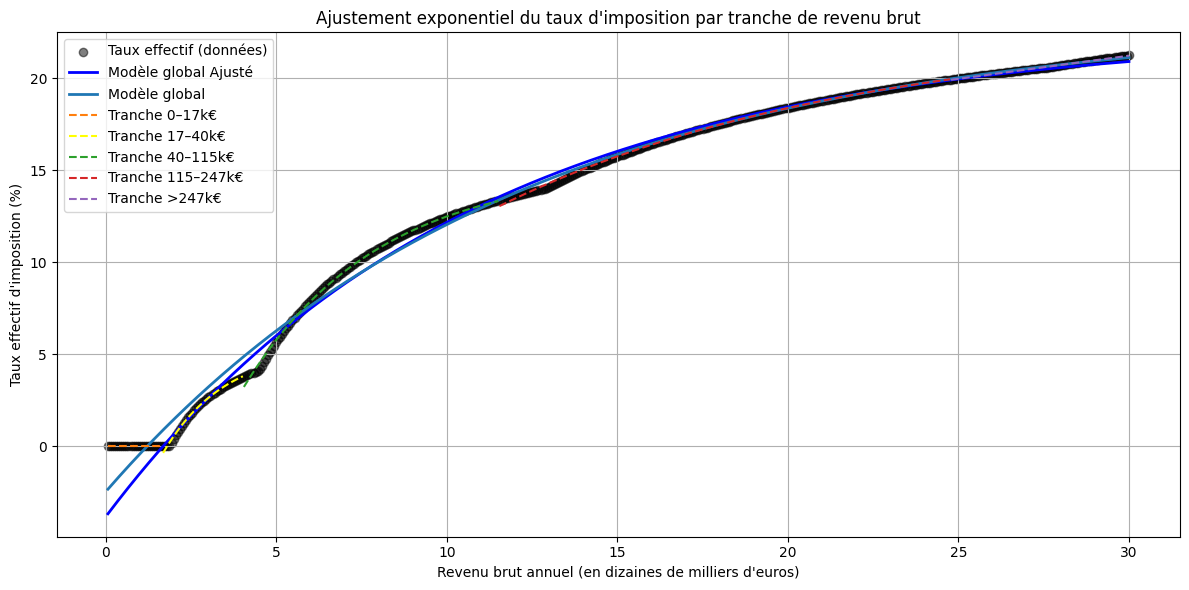

In [13]:
# Génération des courbes ajustées pour chaque tranche
x_fit = np.linspace(min(x), max(x), 1000)
y_total = modele_exp(x_fit, *coeffs_total)
y_total_ajuste=modele_exp(x_fit, *coeffs_total_ajuste)

seuils_bruts_approx = seuils_bruts_approx / 10000  # pour les x en base 10k

# Tranche 1
x1_fit = x_fit[x_fit <= seuils_bruts_approx[0]]
y1_fit = modele_exp(x1_fit, *coeffs_1)

# Tranche 2
x2_fit = x_fit[(x_fit > seuils_bruts_approx[0]) & (x_fit <= seuils_bruts_approx[1])]
y2_fit = modele_exp(x2_fit, *coeffs_2)

# Tranche 3
x3_fit = x_fit[(x_fit > seuils_bruts_approx[1]) & (x_fit <= seuils_bruts_approx[2])]
y3_fit = modele_exp(x3_fit, *coeffs_3)

# Tranche 4
x4_fit = x_fit[(x_fit > seuils_bruts_approx[2]) & (x_fit <= seuils_bruts_approx[3])]
y4_fit = modele_exp(x4_fit, *coeffs_4)

# Tranche 5
x5_fit = x_fit[x_fit > seuils_bruts_approx[3]]
y5_fit = modele_exp(x5_fit, *coeffs_5)

# Tracé
plt.figure(figsize=(12, 6))
plt.scatter(x, y, color='black', alpha=0.5, label="Taux effectif (données)")
plt.plot(x_fit, y_total_ajuste, label="Modèle global Ajusté", color='blue', linewidth=2)
plt.plot(x_fit, y_total, label="Modèle global", linewidth=2)
plt.plot(x1_fit, y1_fit, label="Tranche 0–17k€",linestyle='--')
plt.plot(x2_fit, y2_fit, label="Tranche 17–40k€", color='yellow',linestyle='--')
plt.plot(x3_fit, y3_fit, label="Tranche 40–115k€", linestyle='--')
plt.plot(x4_fit, y4_fit, label="Tranche 115–247k€", linestyle='--')
plt.plot(x5_fit, y5_fit, label="Tranche >247k€", linestyle='--')

plt.xlabel("Revenu brut annuel (en dizaines de milliers d'euros)")
plt.ylabel("Taux effectif d'imposition (%)")
plt.title("Ajustement exponentiel du taux d'imposition par tranche de revenu brut")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
eco_mod = [economie_dechelle(*coeffs) for coeffs in models.values()]

# Create a DataFrame
df_eco_mod = pd.DataFrame({
    "Tranche": list(models.keys()),
    "Result1": [result[0] for result in eco_mod],
    "Result2": [result[1] for result in eco_mod]
})

# Display the DataFrame
print("À partir de quel niveau de salaire, dans chaque intervalle,\n le revenu augmente plus vite que le taux moyen d’imposition ?")
display(df_eco_mod)

À partir de quel niveau de salaire, dans chaque intervalle,
 le revenu augmente plus vite que le taux moyen d’imposition ?


,Tranche,Result1,Result2
0,Totale,-4.610076- 0.000000j,6.211419- 0.000000j
1,Totale_Ajusté,-4.915572- 0.000000j,7.133242- 0.000000j
2,0–17k€,-4.525034- 0.000000j,7.936177- 0.000000j
3,17–40k€,-1.504849- 0.000000j,3.841992- 0.000000j
4,40–115k€,-3.121270- 0.000000j,7.183340- 0.000000j
5,115–247k€,-5.719927- 0.000000j,9.109781- 0.000000j
6,>247k€,-36.118136-1324.113543j,-36.118136+1324.113543j
